<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/S7EVA4_DDilate_MiniRkg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Jun 17 18:59:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models

Mounted at /content/drive


In [ ]:
#!pip install git+https://github.com/rajy4683/RekogNizer.git

In [7]:
!git clone https://github.com/rajy4683/mini-Rekog.git

Cloning into 'mini-Rekog'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 12), reused 37 (delta 9), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [8]:
!pip install -r /content/mini-Rekog/requirements.txt

     |████████████████████████████████| 1.8MB 3.9MB/s 
     |████████████████████████████████| 13.2MB 11.7MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 163kB 35.6MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 634kB 38.3MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=4f681b80abbb6a49485d499b489942f1aa42c68c3544b5e7e9ca77e40cbe74b4
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=a8f9519051dc3de87e6c0e2ab24657901febfff0069c51617ffb4e7f47c9128e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=65401

In [9]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
!pip install -U albumentations

     |████████████████████████████████| 102kB 3.3MB/s 
     |████████████████████████████████| 38.2MB 1.4MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [11]:
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, 
    Resize,RandomSizedCrop, MotionBlur,PadIfNeeded,Flip, IAAFliplr,CoarseDropout,
)

#from albumentations import CoarseDropout 
from albumentations.pytorch import ToTensorV2

In [12]:
import albumentations

In [13]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


sys.path.append('/content/mini-Rekog/')
# sys.path.append('/content/mini-Rekog/miniRekog')
# sys.path.append('/content/drive/MyDrive/EVA4/RekogNizer')

from miniRekog.config.config import config
from miniRekog.models import CIFAR10Models
from miniRekog.utils import fileutils
from miniRekog.dataloaders import dataloader
from miniRekog.train import traintest
# from miniRekog import logger
from torchsummary import summary
import torch
import torch.optim as optim
import torch.nn as nn
import argparse
import json
import torchvision.transforms as transforms
import torchvision
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize,ShiftScaleRotate, CoarseDropout, 
    Resize,RandomSizedCrop, MotionBlur,PadIfNeeded,Flip, IAAFliplr,ToGray,
)
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau
import wandb


In [ ]:
type(config)

miniRekog.config.config.Config

In [14]:
%load_ext autoreload
%autoreload 1

transform_train = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(p=0.5),
    CoarseDropout(max_holes=1, 
                  max_height=16,
                  max_width=16, 
                  min_holes=1, 
                  min_height=16, 
                  min_width=16, 
                  fill_value=[0.49139968, 0.48215841, 0.44653091], 
                  mask_fill_value=None, 
                  always_apply=False, p=0.5),
    Normalize(
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
    ),
    # ToGray(p=1),
    ToTensorV2()
])

transform_test = Compose([
    Normalize(
    mean=[0.49421428, 0.48513139, 0.45040909],
    std=[0.24665252, 0.24289226, 0.26159238],
    ),
    ToTensorV2()
])

trainloader, testloader = dataloader.get_train_test_dataloader_cifar10(transform_train=transform_train, 
                                                                       transform_test=transform_test,
                                                                       config=config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:122: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#trainloader.dataset.data.shape
print(np.mean(trainloader.dataset.data, axis=(0,1,2))/255)
print(np.std(trainloader.dataset.data, axis=(0,1,2))/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [ ]:
print(np.mean(testloader.dataset.data, axis=(0,1,2))/255)
print(np.std(testloader.dataset.data, axis=(0,1,2))/255)

[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]


In [15]:
%load_ext autoreload
%autoreload 2
from torchsummary import summary
device = torch.device("cuda" if not config['no_cuda'] else "cpu")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class CIFARModelDDilate(nn.Module):
    def __init__(self,dropout=0.1):
        super(CIFARModelDDilate, self).__init__()
        self.layer1_channels = 12
        self.dropout_val = dropout
        self.bias = False

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias),
            #nn.Conv2d(3,self.layer1_channels,1,1,0,1,1,bias=bias),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            
            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias),#,groups=self.layer1_channels),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),

            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=2, stride=2, dilation=2, bias=self.bias),#,groups=self.layer1_channels),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            
            nn.Conv2d(self.layer1_channels*2,self.layer1_channels*2,1,1,0,1,1,bias=self.bias),      
            # nn.BatchNorm2d(self.layer1_channels*2),
            # nn.ReLU(),
            # # nn.Conv2d(self.layer1_channels, self.layer1_channels, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias), #groups=self.layer1_channels),
            #nn.Conv2d(self.layer1_channels,self.layer1_channels*2,1,1,0,1,1,bias=self.bias),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            
            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, stride=1,bias=self.bias, groups=self.layer1_channels*2),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),

            nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=2, stride=2, dilation=2, bias=self.bias,groups=self.layer1_channels),
            nn.BatchNorm2d(self.layer1_channels*2),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),

            nn.Conv2d(self.layer1_channels*2,self.layer1_channels*4,1,1,0,1,1,bias=self.bias),      
            # nn.BatchNorm2d(self.layer1_channels*4),
            # nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*2, self.layer1_channels*2, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*2),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=2, stride=1,bias=self.bias,dilation=2), #groups=self.layer1_channels*2),
            #nn.Conv2d(self.layer1_channels*2,self.layer1_channels*4,1,1,0,1,1,bias=self.bias),       
            nn.BatchNorm2d(self.layer1_channels*4),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=2, stride=1,bias=self.bias, groups=self.layer1_channels*4, dilation=2),
            nn.BatchNorm2d(self.layer1_channels*4),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            
            # nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, stride=2,bias=self.bias, groups=self.layer1_channels*4, dilation=1),
            # nn.BatchNorm2d(self.layer1_channels*4),
            # nn.ReLU(),
            # nn.Dropout(self.dropout_val),

            nn.Conv2d(self.layer1_channels*4, self.layer1_channels*8,1,1,0,1,1,bias=self.bias),
            # nn.BatchNorm2d(self.layer1_channels*8),
            # nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*4),
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(self.layer1_channels*8, self.layer1_channels*8, 3, padding=1, stride=1,bias=self.bias),#, groups=self.layer1_channels),            
            nn.BatchNorm2d(self.layer1_channels*8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(self.layer1_channels*8, self.layer1_channels*8, 3, padding=1, stride=1,bias=self.bias, groups=self.layer1_channels),
            nn.BatchNorm2d(self.layer1_channels*8),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),

            # nn.Conv2d(self.layer1_channels*8, self.layer1_channels*8,1,1,0,1,1,bias=self.bias),
            nn.Conv2d(self.layer1_channels*8, 10,1,1,0,1,1,bias=self.bias),
            # nn.BatchNorm2d(self.layer1_channels*8),
            # nn.ReLU(),
            # nn.Conv2d(self.layer1_channels*4, self.layer1_channels*4, 3, padding=1, bias=self.bias),            
            # nn.BatchNorm2d(self.layer1_channels*8),
            # nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            # nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            # nn.AdaptiveAvgPool2d((1,1)),
            nn.AvgPool2d(kernel_size=8),
            # nn.Conv2d(self.layer1_channels*8, 10, 1, bias=self.bias)
        )

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 16 * 5 * 5)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)

        return x

In [34]:
%autoreload 2
model_new = CIFAR10Models.CIFARModelDDilate(0.05).to(device)
summary(model_new,input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
              ReLU-3           [-1, 24, 32, 32]               0
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           5,184
       BatchNorm2d-6           [-1, 24, 32, 32]              48
              ReLU-7           [-1, 24, 32, 32]               0
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9           [-1, 24, 16, 16]           5,184
      BatchNorm2d-10           [-1, 24, 16, 16]              48
             ReLU-11           [-1, 24, 16, 16]               0
          Dropout-12           [-1, 24, 16, 16]               0
           Conv2d-13           [-1, 24, 16, 16]             576
           Conv2d-14           [-1, 24,

torch.Size([512, 3, 32, 32]) tensor([-0.2441, -0.2501, -0.2097]) tensor([1.1368, 1.1342, 1.0940])
 ship  deer plane  frog   cat   cat   car horse   car   car truck   car  bird   cat  ship truck   cat   car plane  deer  frog  ship  deer horse  ship  deer truck  deer  ship   car plane   car


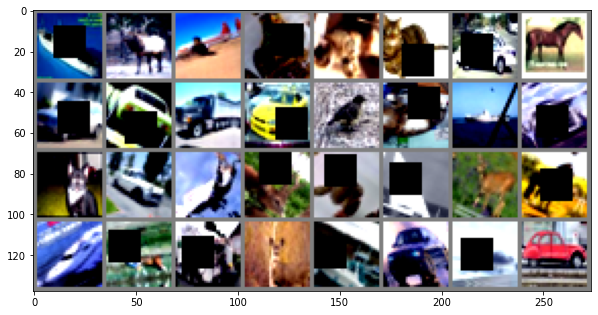

In [35]:
%autoreload 1
from miniRekog.dataloaders import dataloader
from miniRekog.train import traintest
fileutils.get_image_samples(trainloader, dataloader.cifar10_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32]) tensor([0.0310, 0.0325, 0.0282]) tensor([1.0099, 1.0143, 1.0083])
  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


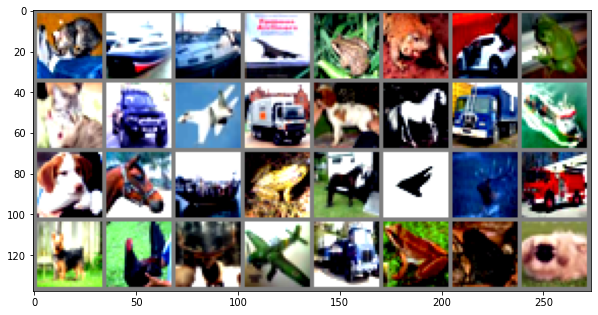

In [19]:
fileutils.get_image_samples(testloader, dataloader.cifar10_classes)

In [20]:
# model_new = basemodelclass.CIFARModelDepthDilate().to(device)
# summary(model_new,input_size=(3, 32, 32))
from miniRekog.config.config import Config

config = Config(
    dropout = 0.1,
    batch_size = 512,
    test_batch_size=128,
    lr = 0.1,
    momentum = 0.9,
    no_cuda = False,
    seed = 1,
    epochs = 24,
    bias = False,
    sched_lr_gamma = 0.5, ## Gamma to apply for StepLR
    sched_lr_step= 1, ## After how many steps LR will be reduced
    start_lr = 0, ## After how many epochs to start StepLR scheduling
    weight_decay=0.0000, ### Weight decay value
    reg_l1=False, ## Enable L1 regularization 
    reg_l2=False, ## Enable L2 regularization 
    norm_strategy="BatchNorm", ## Which Normalization scheme to use i.e BN/GN/LN
    lr_decay_threshold=0.0,
    factor=0.0,
    project="news5",
    ocp_max_lr=0.5,
    final_div_factor=64,
    div_factor=128,
    anneal_strategy='linear',
    pct_start=0.208,
    cycle_momentum=False,
    lr_policy="ocp",
    split_pct=0.208,
    unfreeze_layer=3,
)

In [17]:
config.set('run_name',fileutils.rand_run_name())
config.set('epochs',100)
config.set('cycle_momentum', True)
# hyperparams.hyperparameter_defaults['epochs']=100
wandb_run_init = wandb.init(config=config.get_dict(), project=config.get('project'))
# wandb.watch_called = False
wandb_config = wandb.config
print(wandb_config)
# wandb.watch(model_new, log="all")


optimizer=optim.SGD(model_new.parameters(), lr=wandb_config.lr,momentum=wandb_config.momentum,
                        weight_decay=wandb_config.weight_decay)

#optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss
cycle_momentum = True if wandb_config.cycle_momentum == "True" else False
print("Momentum cycling set to {}".format(cycle_momentum))
#scheduler = CyclicLR(optimizer, base_lr=wandb_config.lr*0.01, max_lr=wandb_config.lr, mode='triangular', gamma=1., cycle_momentum=True,step_size_up=2000)#, scale_fn='triangular',step_size_up=200)
scheduler = OneCycleLR(optimizer, 
                        wandb_config.ocp_max_lr, 
                        epochs=wandb_config.epochs, 
                        cycle_momentum=cycle_momentum, 
                        steps_per_epoch=len(trainloader), 
                        base_momentum=wandb_config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=wandb_config.anneal_strategy,
                        div_factor=wandb_config.div_factor,
                        final_div_factor=wandb_config.final_div_factor
                        )

# traintest.execute_model(model_new, hyperparams.hyperparameter_defaults, 
#               trainloader, testloader, 
#               device, classes,
#               optimizer=optimizer,
#               criterion=criterion,
#               prev_saved_model="/content/drive/My Drive/EVA4/model_saves/model-33ef5baa01.h5")

final_model_path = traintest.execute_model(model_new, 
            config, 
            trainloader, testloader, 
            device, dataloader.cifar10_classes,
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)


Train Accuracy,22.02
Train Loss,2.06969
Test Accuracy,34.72
Test Loss,1.75209
Learning Rate,0
_runtime,44
_timestamp,1623931856
_step,0


Train Accuracy,▁
Train Loss,▁
Test Accuracy,▁
Test Loss,▁
Learning Rate,▁
_runtime,▁
_timestamp,▁
_step,▁


  0%|          | 0/98 [00:00<?, ?it/s]

{'dropout': 0.1, 'batch_size': 512, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'epochs': 100, 'bias': False, 'sched_lr_gamma': 0.5, 'sched_lr_step': 1, 'start_lr': 0, 'weight_decay': 0.0, 'reg_l1': False, 'reg_l2': False, 'norm_strategy': 'BatchNorm', 'lr_decay_threshold': 0.0, 'factor': 0.0, 'project': 'news5', 'ocp_max_lr': 0.5, 'final_div_factor': 64, 'div_factor': 128, 'anneal_strategy': 'linear', 'pct_start': 0.208, 'cycle_momentum': True, 'lr_policy': 'ocp', 'split_pct': 0.208, 'unfreeze_layer': 3, 'run_name': '4ed1ee09dc'}
Momentum cycling set to False
Model saved to:  /content/model_saves/model-4ed1ee09dc.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 224, 224]             648
       BatchNorm2d-2         [-1, 24, 224, 224]              48
              ReLU-3         [-1, 24, 224, 224]               0
           Dropou

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 1.6997, Accuracy: 36.630%, lr:0
Epoch: 1 Test set: Average loss: 1.5371, Accuracy: 43.800%
Model saved as Test Accuracy increased from  0.0  to  43.8


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 1.5620, Accuracy: 42.438%, lr:0
Epoch: 2 Test set: Average loss: 1.5031, Accuracy: 45.820%
Model saved as Test Accuracy increased from  43.8  to  45.82


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 1.4711, Accuracy: 46.214%, lr:0
Epoch: 3 Test set: Average loss: 1.2504, Accuracy: 54.070%
Model saved as Test Accuracy increased from  45.82  to  54.07


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 1.3781, Accuracy: 50.084%, lr:0
Epoch: 4 Test set: Average loss: 1.2449, Accuracy: 55.220%
Model saved as Test Accuracy increased from  54.07  to  55.22


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 1.3372, Accuracy: 51.550%, lr:0
Epoch: 5 Test set: Average loss: 1.1931, Accuracy: 58.310%
Model saved as Test Accuracy increased from  55.22  to  58.31


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 1.2771, Accuracy: 53.918%, lr:0
Epoch: 6 Test set: Average loss: 1.0708, Accuracy: 61.970%
Model saved as Test Accuracy increased from  58.31  to  61.97


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 1.2553, Accuracy: 55.202%, lr:0
Epoch: 7 Test set: Average loss: 1.1019, Accuracy: 61.300%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 1.2221, Accuracy: 56.432%, lr:0
Epoch: 8 Test set: Average loss: 1.3104, Accuracy: 54.650%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 1.1969, Accuracy: 57.010%, lr:0
Epoch: 9 Test set: Average loss: 1.0218, Accuracy: 64.770%
Model saved as Test Accuracy increased from  61.97  to  64.77


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 1.1596, Accuracy: 58.500%, lr:0
Epoch: 10 Test set: Average loss: 0.9169, Accuracy: 67.920%
Model saved as Test Accuracy increased from  64.77  to  67.92


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 1.1611, Accuracy: 58.796%, lr:0
Epoch: 11 Test set: Average loss: 0.9205, Accuracy: 67.560%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 1.1330, Accuracy: 59.950%, lr:0
Epoch: 12 Test set: Average loss: 0.8937, Accuracy: 68.930%
Model saved as Test Accuracy increased from  67.92  to  68.93


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 1.1293, Accuracy: 59.754%, lr:0
Epoch: 13 Test set: Average loss: 0.8693, Accuracy: 69.440%
Model saved as Test Accuracy increased from  68.93  to  69.44


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 1.0972, Accuracy: 61.012%, lr:0
Epoch: 14 Test set: Average loss: 0.8824, Accuracy: 68.490%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 1.0748, Accuracy: 61.974%, lr:0
Epoch: 15 Test set: Average loss: 0.8718, Accuracy: 69.350%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 1.0703, Accuracy: 62.100%, lr:0
Epoch: 16 Test set: Average loss: 0.8359, Accuracy: 70.990%
Model saved as Test Accuracy increased from  69.44  to  70.99


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 1.0682, Accuracy: 61.946%, lr:0
Epoch: 17 Test set: Average loss: 0.8213, Accuracy: 71.010%
Model saved as Test Accuracy increased from  70.99  to  71.01


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 1.0465, Accuracy: 63.124%, lr:0
Epoch: 18 Test set: Average loss: 0.8524, Accuracy: 70.390%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 1.0514, Accuracy: 63.060%, lr:0
Epoch: 19 Test set: Average loss: 0.8236, Accuracy: 71.570%
Model saved as Test Accuracy increased from  71.01  to  71.57


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 1.0279, Accuracy: 63.646%, lr:0
Epoch: 20 Test set: Average loss: 0.7766, Accuracy: 72.630%
Model saved as Test Accuracy increased from  71.57  to  72.63


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 1.0223, Accuracy: 63.880%, lr:0
Epoch: 21 Test set: Average loss: 0.9087, Accuracy: 68.780%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 1.0114, Accuracy: 64.218%, lr:0
Epoch: 22 Test set: Average loss: 0.8969, Accuracy: 69.050%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.9987, Accuracy: 64.856%, lr:0
Epoch: 23 Test set: Average loss: 0.7580, Accuracy: 74.420%
Model saved as Test Accuracy increased from  72.63  to  74.42


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.9801, Accuracy: 65.426%, lr:0
Epoch: 24 Test set: Average loss: 0.7658, Accuracy: 73.750%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.9695, Accuracy: 65.730%, lr:0
Epoch: 25 Test set: Average loss: 0.7514, Accuracy: 74.600%
Model saved as Test Accuracy increased from  74.42  to  74.6


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.9567, Accuracy: 66.226%, lr:0
Epoch: 26 Test set: Average loss: 0.7726, Accuracy: 74.300%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.9484, Accuracy: 66.520%, lr:0
Epoch: 27 Test set: Average loss: 0.6856, Accuracy: 76.490%
Model saved as Test Accuracy increased from  74.6  to  76.49


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.9415, Accuracy: 66.684%, lr:0
Epoch: 28 Test set: Average loss: 0.6529, Accuracy: 77.370%
Model saved as Test Accuracy increased from  76.49  to  77.37


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.9349, Accuracy: 67.100%, lr:0
Epoch: 29 Test set: Average loss: 0.7649, Accuracy: 73.730%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.9308, Accuracy: 67.112%, lr:0
Epoch: 30 Test set: Average loss: 0.7017, Accuracy: 75.760%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.9192, Accuracy: 67.592%, lr:0
Epoch: 31 Test set: Average loss: 0.6643, Accuracy: 77.040%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.9188, Accuracy: 67.504%, lr:0
Epoch: 32 Test set: Average loss: 0.6522, Accuracy: 77.370%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.9006, Accuracy: 68.284%, lr:0
Epoch: 33 Test set: Average loss: 0.6298, Accuracy: 77.820%
Model saved as Test Accuracy increased from  77.37  to  77.82


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.8966, Accuracy: 68.444%, lr:0
Epoch: 34 Test set: Average loss: 0.6506, Accuracy: 77.730%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.8890, Accuracy: 68.560%, lr:0
Epoch: 35 Test set: Average loss: 0.6613, Accuracy: 77.430%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.8874, Accuracy: 68.686%, lr:0
Epoch: 36 Test set: Average loss: 0.6141, Accuracy: 78.970%
Model saved as Test Accuracy increased from  77.82  to  78.97


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.8836, Accuracy: 68.952%, lr:0
Epoch: 37 Test set: Average loss: 0.6319, Accuracy: 78.640%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.8796, Accuracy: 69.016%, lr:0
Epoch: 38 Test set: Average loss: 0.6292, Accuracy: 78.820%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.8727, Accuracy: 69.328%, lr:0
Epoch: 39 Test set: Average loss: 0.6867, Accuracy: 76.740%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 40 Train set: Average loss: 0.8757, Accuracy: 69.238%, lr:0
Epoch: 40 Test set: Average loss: 0.6123, Accuracy: 78.460%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 41 Train set: Average loss: 0.8695, Accuracy: 69.272%, lr:0
Epoch: 41 Test set: Average loss: 0.6101, Accuracy: 78.680%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 42 Train set: Average loss: 0.8539, Accuracy: 69.712%, lr:0
Epoch: 42 Test set: Average loss: 0.6404, Accuracy: 77.380%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 43 Train set: Average loss: 0.8594, Accuracy: 69.662%, lr:0
Epoch: 43 Test set: Average loss: 0.6196, Accuracy: 78.590%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 44 Train set: Average loss: 0.8498, Accuracy: 69.968%, lr:0
Epoch: 44 Test set: Average loss: 0.5878, Accuracy: 79.920%
Model saved as Test Accuracy increased from  78.97  to  79.92


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 45 Train set: Average loss: 0.8430, Accuracy: 70.410%, lr:0
Epoch: 45 Test set: Average loss: 0.5898, Accuracy: 79.900%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 46 Train set: Average loss: 0.8424, Accuracy: 70.000%, lr:0
Epoch: 46 Test set: Average loss: 0.5983, Accuracy: 79.520%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 47 Train set: Average loss: 0.8364, Accuracy: 70.624%, lr:0
Epoch: 47 Test set: Average loss: 0.5974, Accuracy: 79.810%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 48 Train set: Average loss: 0.8280, Accuracy: 70.748%, lr:0
Epoch: 48 Test set: Average loss: 0.5948, Accuracy: 79.570%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 49 Train set: Average loss: 0.8289, Accuracy: 70.906%, lr:0
Epoch: 49 Test set: Average loss: 0.6258, Accuracy: 78.980%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 50 Train set: Average loss: 0.8249, Accuracy: 70.990%, lr:0
Epoch: 50 Test set: Average loss: 0.6066, Accuracy: 79.640%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 51 Train set: Average loss: 0.8250, Accuracy: 71.070%, lr:0
Epoch: 51 Test set: Average loss: 0.6014, Accuracy: 79.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 52 Train set: Average loss: 0.8199, Accuracy: 71.012%, lr:0
Epoch: 52 Test set: Average loss: 0.5835, Accuracy: 80.040%
Model saved as Test Accuracy increased from  79.92  to  80.04


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 53 Train set: Average loss: 0.8226, Accuracy: 70.826%, lr:0
Epoch: 53 Test set: Average loss: 0.5929, Accuracy: 79.210%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 54 Train set: Average loss: 0.8167, Accuracy: 71.286%, lr:0
Epoch: 54 Test set: Average loss: 0.5752, Accuracy: 80.000%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 55 Train set: Average loss: 0.8165, Accuracy: 71.096%, lr:0
Epoch: 55 Test set: Average loss: 0.5979, Accuracy: 79.570%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 56 Train set: Average loss: 0.8134, Accuracy: 71.364%, lr:0
Epoch: 56 Test set: Average loss: 0.5799, Accuracy: 80.210%
Model saved as Test Accuracy increased from  80.04  to  80.21


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 57 Train set: Average loss: 0.8089, Accuracy: 71.594%, lr:0
Epoch: 57 Test set: Average loss: 0.5767, Accuracy: 80.530%
Model saved as Test Accuracy increased from  80.21  to  80.53


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 58 Train set: Average loss: 0.8071, Accuracy: 71.442%, lr:0
Epoch: 58 Test set: Average loss: 0.5531, Accuracy: 81.290%
Model saved as Test Accuracy increased from  80.53  to  81.29


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 59 Train set: Average loss: 0.8015, Accuracy: 71.726%, lr:0
Epoch: 59 Test set: Average loss: 0.5809, Accuracy: 79.890%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 60 Train set: Average loss: 0.7956, Accuracy: 72.106%, lr:0
Epoch: 60 Test set: Average loss: 0.5891, Accuracy: 80.030%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 61 Train set: Average loss: 0.7983, Accuracy: 71.916%, lr:0
Epoch: 61 Test set: Average loss: 0.5468, Accuracy: 81.000%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 62 Train set: Average loss: 0.7997, Accuracy: 71.708%, lr:0
Epoch: 62 Test set: Average loss: 0.5650, Accuracy: 80.650%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 63 Train set: Average loss: 0.7965, Accuracy: 72.006%, lr:0
Epoch: 63 Test set: Average loss: 0.5791, Accuracy: 80.170%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 64 Train set: Average loss: 0.7903, Accuracy: 72.172%, lr:0
Epoch: 64 Test set: Average loss: 0.5466, Accuracy: 81.280%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 65 Train set: Average loss: 0.7862, Accuracy: 72.274%, lr:0
Epoch: 65 Test set: Average loss: 0.5442, Accuracy: 81.450%
Model saved as Test Accuracy increased from  81.29  to  81.45


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 66 Train set: Average loss: 0.7885, Accuracy: 72.354%, lr:0
Epoch: 66 Test set: Average loss: 0.5189, Accuracy: 82.350%
Model saved as Test Accuracy increased from  81.45  to  82.35


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 67 Train set: Average loss: 0.7819, Accuracy: 72.618%, lr:0
Epoch: 67 Test set: Average loss: 0.5467, Accuracy: 81.250%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 68 Train set: Average loss: 0.7797, Accuracy: 72.434%, lr:0
Epoch: 68 Test set: Average loss: 0.5364, Accuracy: 81.510%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 69 Train set: Average loss: 0.7759, Accuracy: 72.600%, lr:0
Epoch: 69 Test set: Average loss: 0.5252, Accuracy: 81.870%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 70 Train set: Average loss: 0.7756, Accuracy: 72.726%, lr:0
Epoch: 70 Test set: Average loss: 0.5278, Accuracy: 81.750%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 71 Train set: Average loss: 0.7804, Accuracy: 72.504%, lr:0
Epoch: 71 Test set: Average loss: 0.5242, Accuracy: 81.850%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 72 Train set: Average loss: 0.7701, Accuracy: 72.904%, lr:0
Epoch: 72 Test set: Average loss: 0.5136, Accuracy: 82.290%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 73 Train set: Average loss: 0.7676, Accuracy: 72.812%, lr:0
Epoch: 73 Test set: Average loss: 0.5440, Accuracy: 81.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 74 Train set: Average loss: 0.7645, Accuracy: 73.168%, lr:0
Epoch: 74 Test set: Average loss: 0.5231, Accuracy: 81.920%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 75 Train set: Average loss: 0.7639, Accuracy: 73.028%, lr:0
Epoch: 75 Test set: Average loss: 0.5287, Accuracy: 81.910%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 76 Train set: Average loss: 0.7588, Accuracy: 73.268%, lr:0
Epoch: 76 Test set: Average loss: 0.5143, Accuracy: 82.270%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 77 Train set: Average loss: 0.7631, Accuracy: 72.982%, lr:0
Epoch: 77 Test set: Average loss: 0.5160, Accuracy: 82.180%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 78 Train set: Average loss: 0.7485, Accuracy: 73.452%, lr:0
Epoch: 78 Test set: Average loss: 0.5089, Accuracy: 82.440%
Model saved as Test Accuracy increased from  82.35  to  82.44


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 79 Train set: Average loss: 0.7495, Accuracy: 73.592%, lr:0
Epoch: 79 Test set: Average loss: 0.5246, Accuracy: 81.950%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 80 Train set: Average loss: 0.7460, Accuracy: 73.896%, lr:0
Epoch: 80 Test set: Average loss: 0.5206, Accuracy: 82.180%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 81 Train set: Average loss: 0.7479, Accuracy: 73.574%, lr:0
Epoch: 81 Test set: Average loss: 0.5062, Accuracy: 82.960%
Model saved as Test Accuracy increased from  82.44  to  82.96


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 82 Train set: Average loss: 0.7493, Accuracy: 73.660%, lr:0
Epoch: 82 Test set: Average loss: 0.5051, Accuracy: 82.980%
Model saved as Test Accuracy increased from  82.96  to  82.98


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 83 Train set: Average loss: 0.7465, Accuracy: 73.642%, lr:0
Epoch: 83 Test set: Average loss: 0.5062, Accuracy: 83.050%
Model saved as Test Accuracy increased from  82.98  to  83.05


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 84 Train set: Average loss: 0.7414, Accuracy: 73.830%, lr:0
Epoch: 84 Test set: Average loss: 0.5175, Accuracy: 82.330%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 85 Train set: Average loss: 0.7424, Accuracy: 73.978%, lr:0
Epoch: 85 Test set: Average loss: 0.4911, Accuracy: 83.300%
Model saved as Test Accuracy increased from  83.05  to  83.3


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 86 Train set: Average loss: 0.7378, Accuracy: 73.964%, lr:0
Epoch: 86 Test set: Average loss: 0.5102, Accuracy: 82.620%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 87 Train set: Average loss: 0.7382, Accuracy: 74.138%, lr:0
Epoch: 87 Test set: Average loss: 0.5073, Accuracy: 83.000%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 88 Train set: Average loss: 0.7303, Accuracy: 74.270%, lr:0
Epoch: 88 Test set: Average loss: 0.5067, Accuracy: 82.830%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 89 Train set: Average loss: 0.7309, Accuracy: 74.150%, lr:0
Epoch: 89 Test set: Average loss: 0.5061, Accuracy: 82.860%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 90 Train set: Average loss: 0.7321, Accuracy: 74.078%, lr:0
Epoch: 90 Test set: Average loss: 0.5052, Accuracy: 82.870%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 91 Train set: Average loss: 0.7361, Accuracy: 74.126%, lr:0
Epoch: 91 Test set: Average loss: 0.4994, Accuracy: 82.780%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 92 Train set: Average loss: 0.7283, Accuracy: 74.418%, lr:0
Epoch: 92 Test set: Average loss: 0.4981, Accuracy: 83.100%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 93 Train set: Average loss: 0.7277, Accuracy: 74.424%, lr:0
Epoch: 93 Test set: Average loss: 0.4915, Accuracy: 83.420%
Model saved as Test Accuracy increased from  83.3  to  83.42


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 94 Train set: Average loss: 0.7251, Accuracy: 74.526%, lr:0
Epoch: 94 Test set: Average loss: 0.4916, Accuracy: 83.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 95 Train set: Average loss: 0.7279, Accuracy: 74.280%, lr:0
Epoch: 95 Test set: Average loss: 0.4970, Accuracy: 83.180%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 96 Train set: Average loss: 0.7148, Accuracy: 74.764%, lr:0
Epoch: 96 Test set: Average loss: 0.4970, Accuracy: 83.190%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 97 Train set: Average loss: 0.7186, Accuracy: 74.858%, lr:0
Epoch: 97 Test set: Average loss: 0.4940, Accuracy: 83.210%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 98 Train set: Average loss: 0.7150, Accuracy: 74.864%, lr:0
Epoch: 98 Test set: Average loss: 0.4925, Accuracy: 83.340%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 99 Train set: Average loss: 0.7186, Accuracy: 74.630%, lr:0
Epoch: 99 Test set: Average loss: 0.4891, Accuracy: 83.520%
Model saved as Test Accuracy increased from  83.42  to  83.52


loss=0.7610974907875061 batch_id=97: 100%|██████████| 98/98 [00:34<00:00,  2.87it/s]



Epoch: 100 Train set: Average loss: 0.7123, Accuracy: 74.884%, lr:0
Epoch: 100 Test set: Average loss: 0.4897, Accuracy: 83.460%
Final model save path: /content/model_saves/model-4ed1ee09dc.pt  best Accuracy: 83.52


In [18]:
config.set('run_name',fileutils.rand_run_name())
config.set('epochs',30)
config.set('cycle_momentum', True)
# config.set('weight_decay', 0.0001)
# hyperparams.hyperparameter_defaults['epochs']=100
wandb_run_init = wandb.init(config=config.get_dict(), project=config.get('project'))
# wandb.watch_called = False
wandb_config = wandb.config
print(wandb_config)
# wandb.watch(model_new, log="all")


optimizer=optim.SGD(model_new.parameters(), lr=wandb_config.lr,momentum=wandb_config.momentum,
                        weight_decay=wandb_config.weight_decay)

#optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss
cycle_momentum = True if wandb_config.cycle_momentum == "True" else False
print("Momentum cycling set to {}".format(cycle_momentum))
#scheduler = CyclicLR(optimizer, base_lr=wandb_config.lr*0.01, max_lr=wandb_config.lr, mode='triangular', gamma=1., cycle_momentum=True,step_size_up=2000)#, scale_fn='triangular',step_size_up=200)
scheduler = CyclicLR(optimizer,
                      base_lr=config.lr*0.01, 
                      max_lr=config.lr, 
                      mode='triangular', 
                      gamma=1., 
                      cycle_momentum=True,
                      step_size_up=2000)


final_model_path = traintest.execute_model(model_new, 
            config, 
            trainloader, testloader, 
            device, dataloader.cifar10_classes,
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model='/content/model_saves/model-4ed1ee09dc.pt',
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)


Train Accuracy,74.884
Train Loss,0.71234
Test Accuracy,83.46
Test Loss,0.48967
Learning Rate,0
_runtime,3654
_timestamp,1623935812
_step,99


Train Accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Train Loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▁▃▄▃▅▆▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
Test Loss,█▆▅▆▄▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


  0%|          | 0/98 [00:00<?, ?it/s]

{'dropout': 0.1, 'batch_size': 512, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'epochs': 30, 'bias': False, 'sched_lr_gamma': 0.5, 'sched_lr_step': 1, 'start_lr': 0, 'weight_decay': 0.0, 'reg_l1': False, 'reg_l2': False, 'norm_strategy': 'BatchNorm', 'lr_decay_threshold': 0.0, 'factor': 0.0, 'project': 'news5', 'ocp_max_lr': 0.5, 'final_div_factor': 64, 'div_factor': 128, 'anneal_strategy': 'linear', 'pct_start': 0.208, 'cycle_momentum': True, 'lr_policy': 'ocp', 'split_pct': 0.208, 'unfreeze_layer': 3, 'run_name': '2ddf652f47'}
Momentum cycling set to False
Model saved to:  /content/model_saves/model-2ddf652f47.pt
Model loaded from  /content/model_saves/model-4ed1ee09dc.pt  with previous accuracy: 83.52
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 224, 224]             648
       BatchNorm2d-2         [-1, 24, 224, 224]        

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.7143, Accuracy: 74.818%, lr:0
Epoch: 1 Test set: Average loss: 0.4889, Accuracy: 83.520%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.7144, Accuracy: 74.728%, lr:0
Epoch: 2 Test set: Average loss: 0.4897, Accuracy: 83.380%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.7144, Accuracy: 74.904%, lr:0
Epoch: 3 Test set: Average loss: 0.4921, Accuracy: 83.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.7066, Accuracy: 74.964%, lr:0
Epoch: 4 Test set: Average loss: 0.4907, Accuracy: 83.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.7091, Accuracy: 74.814%, lr:0
Epoch: 5 Test set: Average loss: 0.4939, Accuracy: 83.160%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.7134, Accuracy: 74.912%, lr:0
Epoch: 6 Test set: Average loss: 0.4896, Accuracy: 83.490%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.7168, Accuracy: 74.826%, lr:0
Epoch: 7 Test set: Average loss: 0.4937, Accuracy: 83.100%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.7173, Accuracy: 74.654%, lr:0
Epoch: 8 Test set: Average loss: 0.4899, Accuracy: 83.560%
Model saved as Test Accuracy increased from  83.52  to  83.56


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.7112, Accuracy: 74.894%, lr:0
Epoch: 9 Test set: Average loss: 0.4986, Accuracy: 83.270%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.7135, Accuracy: 74.742%, lr:0
Epoch: 10 Test set: Average loss: 0.4940, Accuracy: 83.270%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.7154, Accuracy: 74.752%, lr:0
Epoch: 11 Test set: Average loss: 0.4895, Accuracy: 83.280%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.7223, Accuracy: 74.564%, lr:0
Epoch: 12 Test set: Average loss: 0.4892, Accuracy: 83.420%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.7216, Accuracy: 74.374%, lr:0
Epoch: 13 Test set: Average loss: 0.4882, Accuracy: 83.250%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.7177, Accuracy: 74.654%, lr:0
Epoch: 14 Test set: Average loss: 0.4878, Accuracy: 83.500%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.7178, Accuracy: 74.722%, lr:0
Epoch: 15 Test set: Average loss: 0.4902, Accuracy: 83.270%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.7171, Accuracy: 74.660%, lr:0
Epoch: 16 Test set: Average loss: 0.4895, Accuracy: 83.360%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.7214, Accuracy: 74.800%, lr:0
Epoch: 17 Test set: Average loss: 0.4919, Accuracy: 83.350%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.7129, Accuracy: 74.816%, lr:0
Epoch: 18 Test set: Average loss: 0.4926, Accuracy: 83.440%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.7197, Accuracy: 74.666%, lr:0
Epoch: 19 Test set: Average loss: 0.4911, Accuracy: 83.240%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.7196, Accuracy: 74.726%, lr:0
Epoch: 20 Test set: Average loss: 0.4950, Accuracy: 83.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.7170, Accuracy: 74.762%, lr:0
Epoch: 21 Test set: Average loss: 0.4992, Accuracy: 83.100%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.7152, Accuracy: 74.932%, lr:0
Epoch: 22 Test set: Average loss: 0.4967, Accuracy: 83.220%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.7185, Accuracy: 74.590%, lr:0
Epoch: 23 Test set: Average loss: 0.4910, Accuracy: 83.390%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.7167, Accuracy: 74.784%, lr:0
Epoch: 24 Test set: Average loss: 0.4933, Accuracy: 83.310%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.7140, Accuracy: 74.806%, lr:0
Epoch: 25 Test set: Average loss: 0.4979, Accuracy: 83.410%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.7145, Accuracy: 74.950%, lr:0
Epoch: 26 Test set: Average loss: 0.4924, Accuracy: 83.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.7084, Accuracy: 74.992%, lr:0
Epoch: 27 Test set: Average loss: 0.4945, Accuracy: 83.350%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.7128, Accuracy: 74.862%, lr:0
Epoch: 28 Test set: Average loss: 0.4890, Accuracy: 83.610%
Model saved as Test Accuracy increased from  83.56  to  83.61


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.7082, Accuracy: 74.998%, lr:0
Epoch: 29 Test set: Average loss: 0.4863, Accuracy: 83.540%


loss=0.741962194442749 batch_id=97: 100%|██████████| 98/98 [00:33<00:00,  2.92it/s]



Epoch: 30 Train set: Average loss: 0.7114, Accuracy: 74.890%, lr:0
Epoch: 30 Test set: Average loss: 0.4954, Accuracy: 83.350%
Final model save path: /content/model_saves/model-2ddf652f47.pt  best Accuracy: 83.61


In [19]:
config.set('run_name',fileutils.rand_run_name())
config.set('epochs',20)
config.set('cycle_momentum', True)
# config.set('weight_decay', 0.00001)
# hyperparams.hyperparameter_defaults['epochs']=100
wandb_run_init = wandb.init(config=config.get_dict(), project=config.get('project'))
# wandb.watch_called = False
wandb_config = wandb.config
print(wandb_config)
# wandb.watch(model_new, log="all")


optimizer=optim.SGD(model_new.parameters(), lr=wandb_config.lr,momentum=wandb_config.momentum,
                        weight_decay=wandb_config.weight_decay)

#optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss
cycle_momentum = True if wandb_config.cycle_momentum == "True" else False
print("Momentum cycling set to {}".format(cycle_momentum))
scheduler = CyclicLR(optimizer,
                      base_lr=config.lr*0.01, 
                      max_lr=config.lr, 
                      mode='triangular', 
                      gamma=1., 
                      cycle_momentum=True,
                      step_size_up=200)


final_model_path = traintest.execute_model(model_new, 
            config, 
            trainloader, testloader, 
            device, dataloader.cifar10_classes,
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model='/content/model_saves/model-2ddf652f47.pt',
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)


Train Accuracy,74.89
Train Loss,0.71144
Test Accuracy,83.35
Test Loss,0.49537
Learning Rate,0
_runtime,1095
_timestamp,1623937021
_step,29


Train Accuracy,▆▅▇█▆▇▆▄▇▅▅▃▁▄▅▄▆▆▄▅▅▇▃▆▆▇█▆█▇
Train Loss,▄▄▄▁▂▄▆▆▃▄▅██▆▆▆█▄▇▇▆▅▆▅▄▅▂▄▂▃
Test Accuracy,▇▅▅▅▂▆▁▇▃▃▃▅▃▆▃▅▄▆▃▁▁▃▅▄▅▅▄█▇▄
Test Loss,▂▃▄▃▅▃▅▃█▅▃▃▂▂▃▃▄▄▄▆█▇▄▅▇▄▅▂▁▆
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


  0%|          | 0/98 [00:00<?, ?it/s]

{'dropout': 0.1, 'batch_size': 512, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'epochs': 20, 'bias': False, 'sched_lr_gamma': 0.5, 'sched_lr_step': 1, 'start_lr': 0, 'weight_decay': 1e-05, 'reg_l1': False, 'reg_l2': False, 'norm_strategy': 'BatchNorm', 'lr_decay_threshold': 0.0, 'factor': 0.0, 'project': 'news5', 'ocp_max_lr': 0.5, 'final_div_factor': 64, 'div_factor': 128, 'anneal_strategy': 'linear', 'pct_start': 0.208, 'cycle_momentum': True, 'lr_policy': 'ocp', 'split_pct': 0.208, 'unfreeze_layer': 3, 'run_name': '79b6f13481'}
Momentum cycling set to False
Model saved to:  /content/model_saves/model-79b6f13481.pt
Model loaded from  /content/model_saves/model-2ddf652f47.pt  with previous accuracy: 83.61
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 224, 224]             648
       BatchNorm2d-2         [-1, 24, 224, 224]      

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.7129, Accuracy: 74.924%, lr:0
Epoch: 1 Test set: Average loss: 0.4932, Accuracy: 83.530%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.7145, Accuracy: 74.702%, lr:0
Epoch: 2 Test set: Average loss: 0.4848, Accuracy: 83.690%
Model saved as Test Accuracy increased from  83.61  to  83.69


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.7135, Accuracy: 74.940%, lr:0
Epoch: 3 Test set: Average loss: 0.4873, Accuracy: 83.540%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.7022, Accuracy: 75.170%, lr:0
Epoch: 4 Test set: Average loss: 0.4846, Accuracy: 83.780%
Model saved as Test Accuracy increased from  83.69  to  83.78


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.7007, Accuracy: 75.188%, lr:0
Epoch: 5 Test set: Average loss: 0.4906, Accuracy: 83.530%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.7090, Accuracy: 74.950%, lr:0
Epoch: 6 Test set: Average loss: 0.4835, Accuracy: 83.840%
Model saved as Test Accuracy increased from  83.78  to  83.84


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.7112, Accuracy: 74.996%, lr:0
Epoch: 7 Test set: Average loss: 0.4936, Accuracy: 83.180%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.7091, Accuracy: 74.854%, lr:0
Epoch: 8 Test set: Average loss: 0.4856, Accuracy: 83.540%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.6998, Accuracy: 75.326%, lr:0
Epoch: 9 Test set: Average loss: 0.4930, Accuracy: 83.430%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.7051, Accuracy: 74.974%, lr:0
Epoch: 10 Test set: Average loss: 0.4931, Accuracy: 83.170%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.7090, Accuracy: 74.838%, lr:0
Epoch: 11 Test set: Average loss: 0.4862, Accuracy: 83.650%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.7117, Accuracy: 74.994%, lr:0
Epoch: 12 Test set: Average loss: 0.4864, Accuracy: 83.530%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.7068, Accuracy: 74.970%, lr:0
Epoch: 13 Test set: Average loss: 0.4847, Accuracy: 83.540%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.7058, Accuracy: 75.074%, lr:0
Epoch: 14 Test set: Average loss: 0.4809, Accuracy: 83.510%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.7094, Accuracy: 75.104%, lr:0
Epoch: 15 Test set: Average loss: 0.4870, Accuracy: 83.520%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.7049, Accuracy: 75.040%, lr:0
Epoch: 16 Test set: Average loss: 0.4838, Accuracy: 83.750%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.7041, Accuracy: 75.268%, lr:0
Epoch: 17 Test set: Average loss: 0.4854, Accuracy: 83.590%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.6992, Accuracy: 75.228%, lr:0
Epoch: 18 Test set: Average loss: 0.4899, Accuracy: 83.570%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.7087, Accuracy: 74.964%, lr:0
Epoch: 19 Test set: Average loss: 0.4879, Accuracy: 83.470%


loss=0.6982016563415527 batch_id=97: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]



Epoch: 20 Train set: Average loss: 0.7054, Accuracy: 75.300%, lr:0
Epoch: 20 Test set: Average loss: 0.4919, Accuracy: 83.480%
Final model save path: /content/model_saves/model-79b6f13481.pt  best Accuracy: 83.84


In [25]:
config.set('run_name',fileutils.rand_run_name())
config.set('epochs',100)
config.set('cycle_momentum', True)
config.set('weight_decay', 1e-5)
config.set('batch_size', 256)
# hyperparams.hyperparameter_defaults['epochs']=100
wandb_run_init = wandb.init(config=config.get_dict(), project=config.get('project'))
# wandb.watch_called = False
wandb_config = wandb.config
print(wandb_config)
# wandb.watch(model_new, log="all")


optimizer=optim.SGD(model_new.parameters(), lr=wandb_config.lr,momentum=wandb_config.momentum,
                        weight_decay=wandb_config.weight_decay)

#optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss
cycle_momentum = True if wandb_config.cycle_momentum == "True" else False
print("Momentum cycling set to {}".format(cycle_momentum))
#scheduler = CyclicLR(optimizer, base_lr=wandb_config.lr*0.01, max_lr=wandb_config.lr, mode='triangular', gamma=1., cycle_momentum=True,step_size_up=2000)#, scale_fn='triangular',step_size_up=200)
# scheduler = CyclicLR(optimizer,
#                       base_lr=config.lr*0.01, 
#                       max_lr=config.lr, 
#                       mode='triangular', 
#                       gamma=1., 
#                       cycle_momentum=True,
#                       step_size_up=200)


scheduler = OneCycleLR(optimizer, 
                        wandb_config.ocp_max_lr, 
                        epochs=wandb_config.epochs, 
                        cycle_momentum=cycle_momentum, 
                        steps_per_epoch=len(trainloader), 
                        base_momentum=wandb_config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=wandb_config.anneal_strategy,
                        div_factor=wandb_config.div_factor,
                        final_div_factor=wandb_config.final_div_factor
                        )

# traintest.execute_model(model_new, hyperparams.hyperparameter_defaults, 
#               trainloader, testloader, 
#               device, classes,
#               optimizer=optimizer,
#               criterion=criterion,
#               prev_saved_model="/content/drive/My Drive/EVA4/model_saves/model-33ef5baa01.h5")

final_model_path = traintest.execute_model(model_new, 
            config, 
            trainloader, testloader, 
            device, dataloader.cifar10_classes,
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model='/content/model_saves/model-79b6f13481.pt',
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)


Train Accuracy,67.914
Train Loss,0.91121
Test Accuracy,78.79
Test Loss,0.61446
Learning Rate,0
_runtime,735
_timestamp,1623942078
_step,19


Train Accuracy,██▇▄▂▁▁▁▁▂▂▂▂▃▃▄▄▄▅▆
Train Loss,▁▁▂▅▇████▇▇▇▇▆▆▅▅▅▄▃
Test Accuracy,██▆▁▁▂▃▂▁▂▃▂▃▄▅▆▆▇▇█
Test Loss,▁▁▃▇█▇▆▇█▇▅▆▆▄▄▃▃▂▂▁
Learning Rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


  0%|          | 0/98 [00:00<?, ?it/s]

{'dropout': 0.1, 'batch_size': 256, 'test_batch_size': 128, 'lr': 0.1, 'momentum': 0.9, 'no_cuda': False, 'seed': 1, 'epochs': 100, 'bias': False, 'sched_lr_gamma': 0.5, 'sched_lr_step': 1, 'start_lr': 0, 'weight_decay': 1e-05, 'reg_l1': False, 'reg_l2': False, 'norm_strategy': 'BatchNorm', 'lr_decay_threshold': 0.0, 'factor': 0.0, 'project': 'news5', 'ocp_max_lr': 0.5, 'final_div_factor': 64, 'div_factor': 128, 'anneal_strategy': 'linear', 'pct_start': 0.208, 'cycle_momentum': True, 'lr_policy': 'ocp', 'split_pct': 0.208, 'unfreeze_layer': 3, 'run_name': '2480711fab'}
Momentum cycling set to False
Model saved to:  /content/model_saves/model-2480711fab.pt
Model loaded from  /content/model_saves/model-79b6f13481.pt  with previous accuracy: 83.84
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 224, 224]             648
       BatchNorm2d-2         [-1, 24, 224, 224]     

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 1 Train set: Average loss: 0.7068, Accuracy: 75.134%, lr:0
Epoch: 1 Test set: Average loss: 0.4885, Accuracy: 83.380%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 2 Train set: Average loss: 0.7032, Accuracy: 75.082%, lr:0
Epoch: 2 Test set: Average loss: 0.4869, Accuracy: 83.790%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 3 Train set: Average loss: 0.7070, Accuracy: 75.162%, lr:0
Epoch: 3 Test set: Average loss: 0.4931, Accuracy: 83.290%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 4 Train set: Average loss: 0.7118, Accuracy: 74.908%, lr:0
Epoch: 4 Test set: Average loss: 0.5028, Accuracy: 82.860%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 5 Train set: Average loss: 0.7189, Accuracy: 74.402%, lr:0
Epoch: 5 Test set: Average loss: 0.5128, Accuracy: 82.620%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.7251, Accuracy: 74.358%, lr:0
Epoch: 6 Test set: Average loss: 0.5096, Accuracy: 82.640%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.7410, Accuracy: 73.990%, lr:0
Epoch: 7 Test set: Average loss: 0.5070, Accuracy: 82.890%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.7497, Accuracy: 73.574%, lr:0
Epoch: 8 Test set: Average loss: 0.5178, Accuracy: 82.520%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.7487, Accuracy: 73.622%, lr:0
Epoch: 9 Test set: Average loss: 0.5753, Accuracy: 80.550%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.7547, Accuracy: 73.148%, lr:0
Epoch: 10 Test set: Average loss: 0.5345, Accuracy: 82.020%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.7650, Accuracy: 72.928%, lr:0
Epoch: 11 Test set: Average loss: 0.5673, Accuracy: 80.770%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.7736, Accuracy: 72.828%, lr:0
Epoch: 12 Test set: Average loss: 0.5280, Accuracy: 82.050%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.7740, Accuracy: 72.670%, lr:0
Epoch: 13 Test set: Average loss: 0.5473, Accuracy: 81.550%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.7825, Accuracy: 72.228%, lr:0
Epoch: 14 Test set: Average loss: 0.5314, Accuracy: 81.530%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.7880, Accuracy: 72.302%, lr:0
Epoch: 15 Test set: Average loss: 0.5300, Accuracy: 81.930%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.7857, Accuracy: 72.532%, lr:0
Epoch: 16 Test set: Average loss: 0.5351, Accuracy: 81.390%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.7998, Accuracy: 71.950%, lr:0
Epoch: 17 Test set: Average loss: 0.5860, Accuracy: 80.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.7958, Accuracy: 71.932%, lr:0
Epoch: 18 Test set: Average loss: 0.5932, Accuracy: 79.820%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.8073, Accuracy: 71.660%, lr:0
Epoch: 19 Test set: Average loss: 0.5401, Accuracy: 81.500%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 20 Train set: Average loss: 0.8023, Accuracy: 71.778%, lr:0
Epoch: 20 Test set: Average loss: 0.5660, Accuracy: 80.370%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 21 Train set: Average loss: 0.8085, Accuracy: 71.432%, lr:0
Epoch: 21 Test set: Average loss: 0.5525, Accuracy: 81.140%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 22 Train set: Average loss: 0.8007, Accuracy: 71.702%, lr:0
Epoch: 22 Test set: Average loss: 0.6230, Accuracy: 79.120%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 23 Train set: Average loss: 0.8041, Accuracy: 71.488%, lr:0
Epoch: 23 Test set: Average loss: 0.6144, Accuracy: 79.590%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 24 Train set: Average loss: 0.8056, Accuracy: 71.782%, lr:0
Epoch: 24 Test set: Average loss: 0.6338, Accuracy: 78.670%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 25 Train set: Average loss: 0.7966, Accuracy: 71.914%, lr:0
Epoch: 25 Test set: Average loss: 0.5562, Accuracy: 81.160%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 26 Train set: Average loss: 0.7969, Accuracy: 72.176%, lr:0
Epoch: 26 Test set: Average loss: 0.5727, Accuracy: 80.570%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 27 Train set: Average loss: 0.7951, Accuracy: 72.024%, lr:0
Epoch: 27 Test set: Average loss: 0.5368, Accuracy: 81.940%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 28 Train set: Average loss: 0.7908, Accuracy: 72.256%, lr:0
Epoch: 28 Test set: Average loss: 0.5335, Accuracy: 81.840%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 29 Train set: Average loss: 0.7970, Accuracy: 72.080%, lr:0
Epoch: 29 Test set: Average loss: 0.5858, Accuracy: 80.230%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 30 Train set: Average loss: 0.7894, Accuracy: 72.004%, lr:0
Epoch: 30 Test set: Average loss: 0.5369, Accuracy: 81.650%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 31 Train set: Average loss: 0.7851, Accuracy: 72.422%, lr:0
Epoch: 31 Test set: Average loss: 0.5378, Accuracy: 81.770%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 32 Train set: Average loss: 0.7877, Accuracy: 72.208%, lr:0
Epoch: 32 Test set: Average loss: 0.5666, Accuracy: 80.850%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 33 Train set: Average loss: 0.7745, Accuracy: 72.772%, lr:0
Epoch: 33 Test set: Average loss: 0.5420, Accuracy: 81.820%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 34 Train set: Average loss: 0.7771, Accuracy: 72.362%, lr:0
Epoch: 34 Test set: Average loss: 0.5718, Accuracy: 80.940%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 35 Train set: Average loss: 0.7807, Accuracy: 72.594%, lr:0
Epoch: 35 Test set: Average loss: 0.5502, Accuracy: 81.190%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 36 Train set: Average loss: 0.7761, Accuracy: 72.616%, lr:0
Epoch: 36 Test set: Average loss: 0.5219, Accuracy: 82.210%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 37 Train set: Average loss: 0.7711, Accuracy: 72.706%, lr:0
Epoch: 37 Test set: Average loss: 0.5242, Accuracy: 82.190%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 38 Train set: Average loss: 0.7775, Accuracy: 72.696%, lr:0
Epoch: 38 Test set: Average loss: 0.5292, Accuracy: 82.210%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 39 Train set: Average loss: 0.7739, Accuracy: 72.832%, lr:0
Epoch: 39 Test set: Average loss: 0.5688, Accuracy: 80.800%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 40 Train set: Average loss: 0.7736, Accuracy: 72.726%, lr:0
Epoch: 40 Test set: Average loss: 0.5017, Accuracy: 82.670%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 41 Train set: Average loss: 0.7638, Accuracy: 72.790%, lr:0
Epoch: 41 Test set: Average loss: 0.5143, Accuracy: 82.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 42 Train set: Average loss: 0.7585, Accuracy: 73.394%, lr:0
Epoch: 42 Test set: Average loss: 0.5551, Accuracy: 80.890%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 43 Train set: Average loss: 0.7682, Accuracy: 72.796%, lr:0
Epoch: 43 Test set: Average loss: 0.5108, Accuracy: 82.790%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 44 Train set: Average loss: 0.7556, Accuracy: 73.298%, lr:0
Epoch: 44 Test set: Average loss: 0.5171, Accuracy: 82.400%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 45 Train set: Average loss: 0.7621, Accuracy: 73.166%, lr:0
Epoch: 45 Test set: Average loss: 0.5152, Accuracy: 82.690%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 46 Train set: Average loss: 0.7493, Accuracy: 73.612%, lr:0
Epoch: 46 Test set: Average loss: 0.5374, Accuracy: 81.810%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 47 Train set: Average loss: 0.7546, Accuracy: 73.644%, lr:0
Epoch: 47 Test set: Average loss: 0.5304, Accuracy: 82.110%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 48 Train set: Average loss: 0.7418, Accuracy: 73.734%, lr:0
Epoch: 48 Test set: Average loss: 0.5294, Accuracy: 82.200%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 49 Train set: Average loss: 0.7426, Accuracy: 73.904%, lr:0
Epoch: 49 Test set: Average loss: 0.5381, Accuracy: 81.970%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 50 Train set: Average loss: 0.7462, Accuracy: 73.658%, lr:0
Epoch: 50 Test set: Average loss: 0.5377, Accuracy: 81.660%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 51 Train set: Average loss: 0.7430, Accuracy: 73.858%, lr:0
Epoch: 51 Test set: Average loss: 0.5089, Accuracy: 82.550%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 52 Train set: Average loss: 0.7422, Accuracy: 73.944%, lr:0
Epoch: 52 Test set: Average loss: 0.5224, Accuracy: 82.610%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 53 Train set: Average loss: 0.7483, Accuracy: 73.470%, lr:0
Epoch: 53 Test set: Average loss: 0.5253, Accuracy: 82.230%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 54 Train set: Average loss: 0.7386, Accuracy: 73.966%, lr:0
Epoch: 54 Test set: Average loss: 0.4954, Accuracy: 82.870%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 55 Train set: Average loss: 0.7374, Accuracy: 74.022%, lr:0
Epoch: 55 Test set: Average loss: 0.5437, Accuracy: 81.800%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 56 Train set: Average loss: 0.7415, Accuracy: 73.748%, lr:0
Epoch: 56 Test set: Average loss: 0.5047, Accuracy: 83.180%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 57 Train set: Average loss: 0.7352, Accuracy: 74.166%, lr:0
Epoch: 57 Test set: Average loss: 0.5048, Accuracy: 83.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 58 Train set: Average loss: 0.7325, Accuracy: 74.078%, lr:0
Epoch: 58 Test set: Average loss: 0.4970, Accuracy: 83.320%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 59 Train set: Average loss: 0.7325, Accuracy: 74.378%, lr:0
Epoch: 59 Test set: Average loss: 0.5049, Accuracy: 83.010%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 60 Train set: Average loss: 0.7278, Accuracy: 74.394%, lr:0
Epoch: 60 Test set: Average loss: 0.5206, Accuracy: 82.240%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 61 Train set: Average loss: 0.7284, Accuracy: 74.082%, lr:0
Epoch: 61 Test set: Average loss: 0.4976, Accuracy: 83.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 62 Train set: Average loss: 0.7345, Accuracy: 74.162%, lr:0
Epoch: 62 Test set: Average loss: 0.4955, Accuracy: 83.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 63 Train set: Average loss: 0.7293, Accuracy: 74.250%, lr:0
Epoch: 63 Test set: Average loss: 0.4908, Accuracy: 83.380%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 64 Train set: Average loss: 0.7273, Accuracy: 74.426%, lr:0
Epoch: 64 Test set: Average loss: 0.4996, Accuracy: 83.090%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 65 Train set: Average loss: 0.7206, Accuracy: 74.528%, lr:0
Epoch: 65 Test set: Average loss: 0.4878, Accuracy: 83.580%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 66 Train set: Average loss: 0.7222, Accuracy: 74.712%, lr:0
Epoch: 66 Test set: Average loss: 0.4777, Accuracy: 83.870%
Model saved as Test Accuracy increased from  83.84  to  83.87


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 67 Train set: Average loss: 0.7177, Accuracy: 74.910%, lr:0
Epoch: 67 Test set: Average loss: 0.4814, Accuracy: 83.360%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 68 Train set: Average loss: 0.7133, Accuracy: 74.920%, lr:0
Epoch: 68 Test set: Average loss: 0.4798, Accuracy: 83.560%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 69 Train set: Average loss: 0.7153, Accuracy: 74.728%, lr:0
Epoch: 69 Test set: Average loss: 0.4711, Accuracy: 83.980%
Model saved as Test Accuracy increased from  83.87  to  83.98


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 70 Train set: Average loss: 0.7131, Accuracy: 74.896%, lr:0
Epoch: 70 Test set: Average loss: 0.4863, Accuracy: 83.690%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 71 Train set: Average loss: 0.7142, Accuracy: 74.910%, lr:0
Epoch: 71 Test set: Average loss: 0.4712, Accuracy: 83.770%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 72 Train set: Average loss: 0.7034, Accuracy: 75.238%, lr:0
Epoch: 72 Test set: Average loss: 0.4756, Accuracy: 83.850%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 73 Train set: Average loss: 0.7101, Accuracy: 74.812%, lr:0
Epoch: 73 Test set: Average loss: 0.4911, Accuracy: 83.410%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 74 Train set: Average loss: 0.7049, Accuracy: 75.182%, lr:0
Epoch: 74 Test set: Average loss: 0.4808, Accuracy: 83.830%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 75 Train set: Average loss: 0.7061, Accuracy: 75.060%, lr:0
Epoch: 75 Test set: Average loss: 0.4941, Accuracy: 83.240%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 76 Train set: Average loss: 0.7034, Accuracy: 75.126%, lr:0
Epoch: 76 Test set: Average loss: 0.4658, Accuracy: 84.020%
Model saved as Test Accuracy increased from  83.98  to  84.02


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 77 Train set: Average loss: 0.7050, Accuracy: 75.102%, lr:0
Epoch: 77 Test set: Average loss: 0.4630, Accuracy: 84.170%
Model saved as Test Accuracy increased from  84.02  to  84.17


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 78 Train set: Average loss: 0.6954, Accuracy: 75.376%, lr:0
Epoch: 78 Test set: Average loss: 0.4710, Accuracy: 84.060%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 79 Train set: Average loss: 0.6966, Accuracy: 75.266%, lr:0
Epoch: 79 Test set: Average loss: 0.4790, Accuracy: 83.890%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 80 Train set: Average loss: 0.6892, Accuracy: 75.764%, lr:0
Epoch: 80 Test set: Average loss: 0.4851, Accuracy: 83.550%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 81 Train set: Average loss: 0.6957, Accuracy: 75.470%, lr:0
Epoch: 81 Test set: Average loss: 0.4718, Accuracy: 84.090%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 82 Train set: Average loss: 0.6922, Accuracy: 75.690%, lr:0
Epoch: 82 Test set: Average loss: 0.4648, Accuracy: 84.130%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 83 Train set: Average loss: 0.6920, Accuracy: 75.632%, lr:0
Epoch: 83 Test set: Average loss: 0.4625, Accuracy: 84.320%
Model saved as Test Accuracy increased from  84.17  to  84.32


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 84 Train set: Average loss: 0.6849, Accuracy: 75.786%, lr:0
Epoch: 84 Test set: Average loss: 0.4703, Accuracy: 84.020%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 85 Train set: Average loss: 0.6870, Accuracy: 75.746%, lr:0
Epoch: 85 Test set: Average loss: 0.4482, Accuracy: 84.420%
Model saved as Test Accuracy increased from  84.32  to  84.42


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 86 Train set: Average loss: 0.6828, Accuracy: 75.910%, lr:0
Epoch: 86 Test set: Average loss: 0.4644, Accuracy: 84.250%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 87 Train set: Average loss: 0.6824, Accuracy: 75.888%, lr:0
Epoch: 87 Test set: Average loss: 0.4603, Accuracy: 84.630%
Model saved as Test Accuracy increased from  84.42  to  84.63


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 88 Train set: Average loss: 0.6787, Accuracy: 76.090%, lr:0
Epoch: 88 Test set: Average loss: 0.4589, Accuracy: 84.540%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 89 Train set: Average loss: 0.6786, Accuracy: 75.968%, lr:0
Epoch: 89 Test set: Average loss: 0.4585, Accuracy: 84.490%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 90 Train set: Average loss: 0.6776, Accuracy: 76.054%, lr:0
Epoch: 90 Test set: Average loss: 0.4558, Accuracy: 84.350%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 91 Train set: Average loss: 0.6816, Accuracy: 76.028%, lr:0
Epoch: 91 Test set: Average loss: 0.4542, Accuracy: 84.590%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 92 Train set: Average loss: 0.6737, Accuracy: 76.344%, lr:0
Epoch: 92 Test set: Average loss: 0.4538, Accuracy: 84.630%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 93 Train set: Average loss: 0.6758, Accuracy: 76.318%, lr:0
Epoch: 93 Test set: Average loss: 0.4472, Accuracy: 84.510%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 94 Train set: Average loss: 0.6734, Accuracy: 76.086%, lr:0
Epoch: 94 Test set: Average loss: 0.4462, Accuracy: 84.710%
Model saved as Test Accuracy increased from  84.63  to  84.71


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 95 Train set: Average loss: 0.6727, Accuracy: 76.264%, lr:0
Epoch: 95 Test set: Average loss: 0.4527, Accuracy: 84.540%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 96 Train set: Average loss: 0.6627, Accuracy: 76.806%, lr:0
Epoch: 96 Test set: Average loss: 0.4524, Accuracy: 84.630%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 97 Train set: Average loss: 0.6671, Accuracy: 76.626%, lr:0
Epoch: 97 Test set: Average loss: 0.4491, Accuracy: 84.610%


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 98 Train set: Average loss: 0.6638, Accuracy: 76.486%, lr:0
Epoch: 98 Test set: Average loss: 0.4493, Accuracy: 84.800%
Model saved as Test Accuracy increased from  84.71  to  84.8


  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 99 Train set: Average loss: 0.6661, Accuracy: 76.420%, lr:0
Epoch: 99 Test set: Average loss: 0.4466, Accuracy: 84.880%
Model saved as Test Accuracy increased from  84.8  to  84.88


loss=0.6913687586784363 batch_id=97: 100%|██████████| 98/98 [00:33<00:00,  2.89it/s]



Epoch: 100 Train set: Average loss: 0.6645, Accuracy: 76.570%, lr:0
Epoch: 100 Test set: Average loss: 0.4472, Accuracy: 84.910%
Model saved as Test Accuracy increased from  84.88  to  84.91
Final model save path: /content/model_saves/model-2480711fab.pt  best Accuracy: 84.91


## Loss and Accuracy Plots

In [25]:
%autoreload 2
from miniRekog.utils import logger
run_list = ['rajy4683/news5/runs/2jrhkn21', 'rajy4683/news5/runs/vp0qqzat', 'rajy4683/news5/runs/w3fves82', 'rajy4683/news5/runs/2srl4fvh']

runs_df = logger.get_wandb_dataframes(run_list=run_list)
new_df = pd.DataFrame().append(runs_df)

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 10)

import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly"


In [32]:
new_df[['Train Accuracy', 'Test Accuracy']].reset_index(drop=True).plot()

In [33]:
new_df[['Train Loss', 'Test Loss']].reset_index(drop=True).plot()